# Thrombectomy pilot

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
import seaborn as sns


In [5]:
data = pd.read_csv('./data/complete_ml_data.csv')

In [6]:
X_fields = [
        'prior_disability',
        'stroke_severity',
        'onset_to_thrombolysis',
        'age',
        'precise_onset_known',
        'any_afib_diagnosis',
        'onset_to_thrombectomy']



In [7]:
# In data where onset_to_thrombolysis is empty set to 99999
data['onset_to_thrombolysis'] = data['onset_to_thrombolysis'].fillna(99999)
data['arrival_to_thrombectomy_time'] = data['arrival_to_thrombectomy_time'].fillna(99999)
# Limit to stroke severity > 10
data = data[data['stroke_severity'] > 5]

# Where arrival to thrombectomy time is present calculate onset to thrombectomy
data['onset_to_thrombectomy'] = data['arrival_to_thrombectomy_time'] + data['onset_to_arrival_time']
# Set max onset to thrombectomy to 99999
data['onset_to_thrombectomy'] = data['onset_to_thrombectomy'].apply(lambda x: min(x, 99999))

KeyError: 'arrival_to_thrombectomy_time'

In [5]:
data.head()

,stroke_team,male,year,arrive_by_ambulance,onset_to_arrival_time,onset_during_sleep,arrival_to_scan_time,onset_to_scan,infarction,stroke_severity,...,any_afib_diagnosis,afib_anticoagulant,age,onset_to_thrombolysis,thrombolysis,thrombectomy,scan_to_thrombolysis_time,discharge_disability,arrival_to_thrombectomy_time,onset_to_thrombectomy
0,Watford General Hospital,1,2017,1.0,99.0,0,41.0,140.0,1.0,8,...,1,1.0,92.5,99999.0,0,0,NaN,2.0,99999.0,99999.0
3,Princess Royal Hospital Telford,0,2019,1.0,146.0,0,19.0,165.0,1.0,9,...,0,0.0,87.5,99999.0,0,0,NaN,3.0,99999.0,99999.0
6,Pinderfields Hospital,1,2019,1.0,160.0,0,17.0,177.0,1.0,7,...,0,0.0,72.5,194.0,1,0,34.0,2.0,99999.0,99999.0
9,Torbay Hospital,1,2020,1.0,95.0,0,21.0,116.0,1.0,15,...,1,0.0,87.5,118.0,1,0,23.0,6.0,99999.0,99999.0
11,University Hospital of North Durham,0,2018,1.0,91.0,0,2.0,93.0,1.0,16,...,1,1.0,77.5,99999.0,0,0,NaN,3.0,99999.0,99999.0


In [6]:
len(data)

55279

In [7]:
X = data[X_fields]
y = data['discharge_disability'] <= 2

# SPlit 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)


44223

In [8]:
# Fit the model
model = XGBClassifier(verbosity=0, seed=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
# Get ROC AUC
from sklearn.metrics import roc_auc_score
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_probs)

0.8461765521798625

In [20]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Get feature values and SHAP values for arrival_to_thrombectomy_time
feature = 'onset_to_thrombectomy'
feature_index = X_fields.index(feature)
feature_values = X_train[feature].values
shap_values_feature = shap_values[:, feature_index]



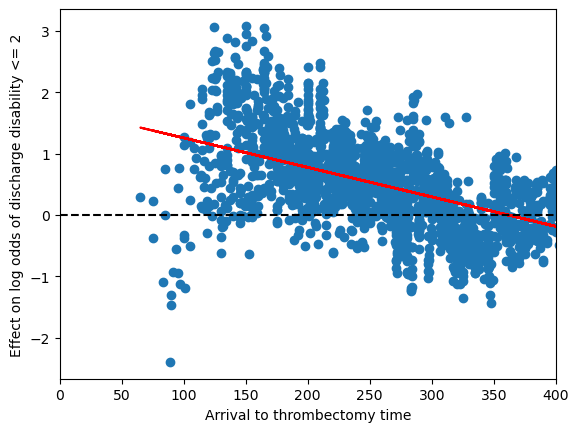

In [21]:
# Scatter plot
# Get data for feature value <600
mask = feature_values < 600
feature_values = feature_values[mask]
shap_values_feature = shap_values_feature[mask]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(feature_values, shap_values_feature)
ax.set_xlabel('Arrival to thrombectomy time')
ax.set_ylabel('Effect on log odds of discharge disability <= 2')
# Fit a regression line and ploit
m, b = np.polyfit(feature_values, shap_values_feature, 1)
ax.plot(feature_values, m*feature_values + b, color='red')
# Add aline at y=0
ax.axhline(y=0, color='black', linestyle='--')
# Set max x to 400 
ax.set_xlim([0, 400])

plt.show()

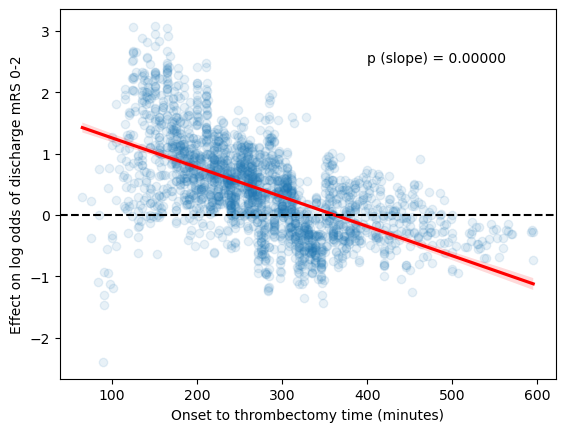

In [23]:
# Plot a seaborn regression plot with confidence limits
sns.regplot(x=feature_values, y=shap_values_feature, ci=95, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.xlabel('Onset to thrombectomy time (minutes)')
plt.ylabel('Effect on log odds of discharge mRS 0-2')
# Add aline at y=0
plt.axhline(y=0, color='black', linestyle='--')
# Add p value
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(feature_values, shap_values_feature)
plt.text(400, 2.5, f'p (slope) = {p_value:.5f}')
# save the plot
plt.savefig('thrombectomy.png', dpi=300)
plt.show()

In [13]:
mask.sum()

2184